## 5.3 RNN 구현
### 5.3.1 RNN 계층 구현
<p align="center">
 <img src = "./fig_5-19.png">
 <img src = "./fig_5-20.png">
</p>

In [1]:
# in ../common/time_layers.py

import numpy as np
# from common.np import *  # import numpy as np (or import cupy as np)
# from common.layers import *
# from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

## 5.3.2 Time RNN 계층 구현
<p align="center">
 <img src = "./fig_5-21.png">
 <img src = "./fig_5-24.png">
</p>

In [2]:
# in ../common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

### 5.5.1 RNN LM 구현
<p align="center">
 <img src = "./fig_5-26.png">
</p>

In [3]:
# %load simple_rnnlm.py
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### 5.5.3 RNN LM의 학습

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 370.88
| 에폭 2 | 퍼플렉서티 278.86
| 에폭 3 | 퍼플렉서티 244.97
| 에폭 4 | 퍼플렉서티 217.84
| 에폭 5 | 퍼플렉서티 208.05
| 에폭 6 | 퍼플렉서티 203.77
| 에폭 7 | 퍼플렉서티 199.16
| 에폭 8 | 퍼플렉서티 195.66
| 에폭 9 | 퍼플렉서티 191.28
| 에폭 10 | 퍼플렉서티 193.12
| 에폭 11 | 퍼플렉서티 188.72
| 에폭 12 | 퍼플렉서티 192.27
| 에폭 13 | 퍼플렉서티 189.37
| 에폭 14 | 퍼플렉서티 189.57
| 에폭 15 | 퍼플렉서티 188.63
| 에폭 16 | 퍼플렉서티 184.88
| 에폭 17 | 퍼플렉서티 181.85
| 에폭 18 | 퍼플렉서티 178.38
| 에폭 19 | 퍼플렉서티 179.29
| 에폭 20 | 퍼플렉서티 180.25
| 에폭 21 | 퍼플렉서티 177.79
| 에폭 22 | 퍼플렉서티 173.35
| 에폭 23 | 퍼플렉서티 170.14
| 에폭 24 | 퍼플렉서티 170.20
| 에폭 25 | 퍼플렉서티 168.16
| 에폭 26 | 퍼플렉서티 166.49
| 에폭 27 | 퍼플렉서티 160.57
| 에폭 28 | 퍼플렉서티 158.18
| 에폭 29 | 퍼플렉서티 156.22
| 에폭 30 | 퍼플렉서티 151.31
| 에폭 31 | 퍼플렉서티 150.94
| 에폭 32 | 퍼플렉서티 143.79
| 에폭 33 | 퍼플렉서티 144.18
| 에폭 34 | 퍼플렉서티 137.72
| 에폭 35 | 퍼플렉서티 135.52
| 에폭 36 | 퍼플렉서티 129.22
| 에폭 37 | 퍼플렉서티 122.67
| 에폭 38 | 퍼플렉서티 118.13
| 에폭 39 | 퍼플렉서티 115.72
| 에폭 40 | 퍼플렉서티 109.57
| 에폭 41 | 퍼플렉서티 109.04
| 에폭 42 | 퍼플렉서티 101.71
| 에폭 43 | 퍼플렉서티 95.

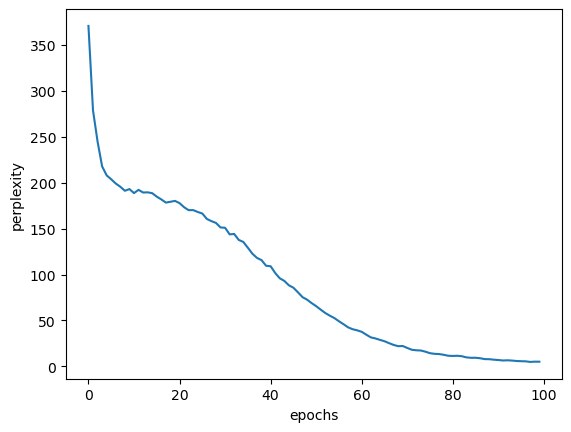

In [4]:
# %load train_custom_loop.py
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD    #확률적 경사 하강법
from dataset import ptb #PTB(Penn Treebank)데이터셋 사용
from simple_rnnlm import SimpleRnnlm    #간단한 RNN 기반 언어 모델 클래스.



# 하이퍼파라미터 설정
batch_size = 10 # 한 번의 학습에서 처리하는 데이터 샘플의 수.
wordvec_size = 100  # 단어 벡터(word embedding)의 차원.
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1          # 학습률(learning rate).   
max_epoch = 100   # 학습 반복 횟수.

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')    # PTB 데이터셋을 불러옵니다.
# word_to_id: 단어를 고유 ID로 변환하는 사전.
# id_to_word: 고유 ID를 단어로 변환하는 사전.
corpus_size = 1000
corpus = corpus[:corpus_size]   # 텍스트 데이터의 단어 ID 시퀀스입니다. 예를 들어, corpus = [5, 8, 2, 1, ...].
vocab_size = int(max(corpus) + 1) # vocab_size : 어휘 수. 최대 단어 ID + 1.

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs) # 입력 데이터 시퀀스.
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)  #입력 시퀀스를 처리하고 다음 단어를 예측.
optimizer = SGD(lr) #확률적 경사 하강법으로 모델의 매개변수 업데이트.

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size # 미니배치를 만들기 위해 데이터 시퀀스를 나누는 간격.
offsets = [i * jump for i in range(batch_size)] # 각 배치 샘플이 시작하는 데이터의 인덱스. 

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        """
        각 배치에서 batch_x는 입력, batch_t는 출력(정답)입니다.
        time_size만큼 시퀀스를 생성.
        순환적 인덱스 계산:
        (offset + time_idx) % data_size로 데이터가 순환하도록 설정.
        """

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        """
        순전파(forward):
            입력(batch_x)과 출력(batch_t)을 모델에 전달해 손실(loss) 계산.
        역전파(backward):
            손실에 따른 모델의 기울기(gradient) 계산.
        매개변수 업데이트:
            optimizer.update로 기울기를 사용해 매개변수 갱신.
        """
        

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    """
    퍼플렉서티(Perplexity):
        언어 모델의 성능을 평가하는 지표.
        낮을수록 좋으며, 모델이 텍스트를 더 잘 예측한다는 뜻.
    """

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## 5.5.4 Trainer 클래스 이용한 RNN LM 학습

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.94
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 372.89
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 257.99
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 222.16
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 211.11
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.57
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.13
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 199.80
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.94
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.76
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.86
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.72
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.98
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.89
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.10
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.23
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.02
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.39
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 181.27
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 182.39
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.51
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 178.

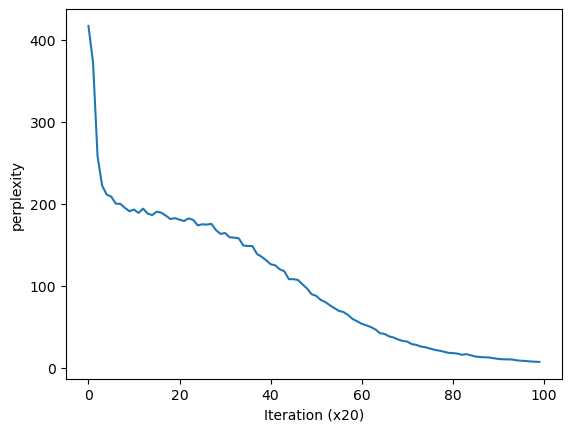

In [5]:
# %load train.py
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer #trainer 클래스 사용
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()